# Introduccion a la Optimizacion de Modelos No Supervisados 
## Analisis de Componentes Principales y Optimizacion con K-Medias

In [1]:
# Importacion de bibliotecas

import argparse # Biblioteca para crear enlaces entre interfaces y mantener estructuras de datos 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler # Normalizador de datos
from sklearn.preprocessing import MinMaxScaler # Normalizador de minimos
from sklearn.decomposition import PCA # Biblioteca de componentes principales
from sklearn.cluster import KMeans # K-medias
import seaborn as sns
from kneed import KneeLocator # Biblioteca que permite pintar puntos de inflexion en funciones (Elbow Method)
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
sns.set()

In [2]:
# Importacion del dataset

data = pd.read_csv('/content/drive/MyDrive/Datasets/data_by_artist.csv', sep= ',')

# Para informacion sobre las variables: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks?select=data_by_artist.csv

In [3]:
# Visualizacion de los datos

data.head(4)

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27


In [4]:
# Inspeccionando tamano del dataset

data.shape

(32539, 15)

In [5]:
# Encontrando datos en NAN
data.isnull().sum()

# Como podemos ver no hay datos nulos

artists             0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
popularity          0
key                 0
mode                0
count               0
dtype: int64

In [6]:
# Validando los tipos de datos en el dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32539 entries, 0 to 32538
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artists           32539 non-null  object 
 1   acousticness      32539 non-null  float64
 2   danceability      32539 non-null  float64
 3   duration_ms       32539 non-null  float64
 4   energy            32539 non-null  float64
 5   instrumentalness  32539 non-null  float64
 6   liveness          32539 non-null  float64
 7   loudness          32539 non-null  float64
 8   speechiness       32539 non-null  float64
 9   tempo             32539 non-null  float64
 10  valence           32539 non-null  float64
 11  popularity        32539 non-null  float64
 12  key               32539 non-null  int64  
 13  mode              32539 non-null  int64  
 14  count             32539 non-null  int64  
dtypes: float64(11), int64(3), object(1)
memory usage: 3.7+ MB


In [7]:
# Comprobando si hay datos duplicados

data.duplicated().sum()

# Como se puede ver no hay datos duplicados, por lo que se procede a extraer

0

In [8]:
# Creando copia de DF original

datos = data.copy()

In [9]:
# Creando nueva estructura sin tomar las variables 'count' y 'artists'
datos = datos.iloc[:, -14:-1]

In [10]:
# Visualizando nuevo dataframe
print(datos)

       acousticness  danceability    duration_ms  ...  popularity  key  mode
0          0.598500      0.470100  267072.000000  ...   38.200000    5     1
1          0.862538      0.441731  287280.000000  ...   31.538462    5     1
2          0.856571      0.348286  328920.000000  ...   34.571429    0     1
3          0.884926      0.425074  262890.962963  ...   34.407407    0     1
4          0.510714      0.467143  270436.142857  ...   42.000000    5     1
...             ...           ...            ...  ...         ...  ...   ...
32534      0.939000      0.174000  341821.000000  ...    0.000000    3     1
32535      0.717000      0.591500  241281.500000  ...   16.000000    1     1
32536      0.416000      0.686000  216715.000000  ...    0.000000    5     0
32537      0.288000      0.739000  242480.000000  ...    8.000000    2     0
32538      0.568000      0.447000  237688.000000  ...   30.000000   10     1

[32539 rows x 13 columns]


In [11]:
# Renombrando variable para utilizarla en Scikit-Learn

X = datos

In [12]:
# Normalizando dataframe
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Componentes Principales como Optimizador de la cantidad de Variables Optimas

In [13]:
# Importando PCA

pca = PCA()
pca.fit(X_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [14]:
# El atributo muestra cuanta varianza es explicada por cada uno de las 13 variables
evr = pca.explained_variance_ratio_
evr

array([0.25178114, 0.11880788, 0.09564738, 0.08780736, 0.07970941,
       0.07692548, 0.0672273 , 0.06201534, 0.05450651, 0.04654405,
       0.02960248, 0.02163162, 0.00779405])

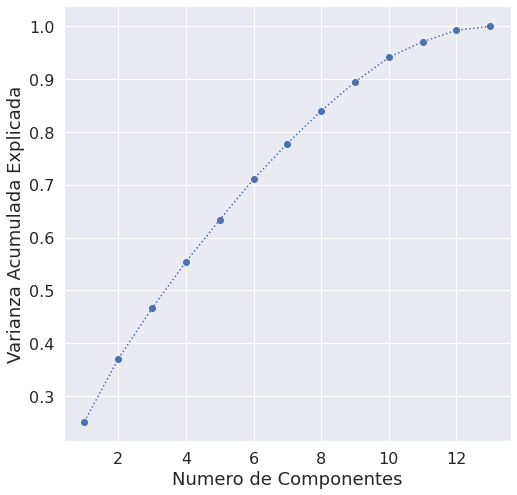

In [15]:
# Ploteando grafico de Componentes principales
fig = plt.figure(figsize=(8,8))
plt.plot(range(1, len(X.columns)+1), evr.cumsum(), marker='o', linestyle=':')
plt.xlabel('Numero de Componentes', fontsize=18)
plt.ylabel('Varianza Acumulada Explicada',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [16]:
# Iteracion para comprobar numero de componentes optimos a utilizar por su nivel de varianza

for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Numero de Componentes Optimos:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(X_std)
scores_pca = pca.transform(X_std)

Numero de Componentes Optimos: 8


### Algoritmo de K-Means

In [17]:
# Encontrando el punto del codo de la curva de WCSS (dentro de la suma de cuadrados) usando el KneedLocator
wcss = []
max_clusters = 21
for i in range(1, max_clusters):
    kmeans_pca = KMeans(i, init='k-means++', random_state=42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)
n_clusters = KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', direction='decreasing').knee
print("Numero de Clusters Optimos:", n_clusters)

Numero de Clusters Optimos: 6


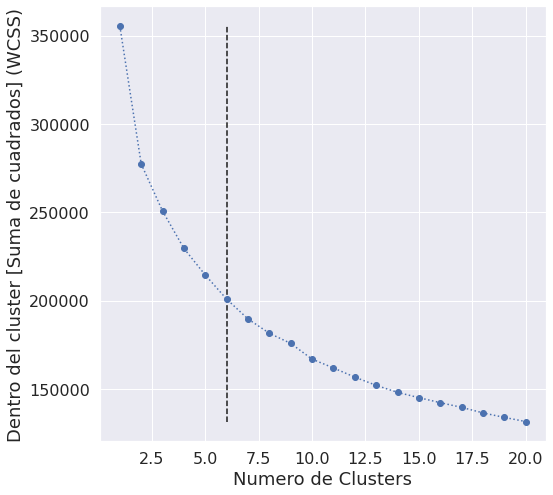

In [18]:
# Ploteando grafico 
fig = plt.figure(figsize=(8,8))
plt.plot(range(1, 21), wcss, marker='o', linestyle=':')
plt.vlines(KneeLocator([i for i in range(1, max_clusters)], wcss, curve='convex', 
                       direction='decreasing').knee, ymin=min(wcss), ymax=max(wcss), linestyles='dashed')
plt.xlabel('Numero de Clusters', fontsize=18)
plt.ylabel('Dentro del cluster [Suma de cuadrados] (WCSS)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [20]:
# Creando la optimizacion de parametros con PCA y K-Means
kmeans_pca = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
kmeans_pca.fit(scores_pca);

### Analisis y Visualizacion

In [23]:
# Etiquentando cada uno de los datos dentro del cluster respectivo
df_seg_pca_kmeans = pd.concat([pd.DataFrame(X.reset_index(drop=True)), pd.DataFrame(scores_pca)], axis=1)
df_seg_pca_kmeans.columns.values[(-1*n_comps):] = ["Component " + str(i+1) for i in range(n_comps)]
df_seg_pca_kmeans['Cluster'] = kmeans_pca.labels_
df_seg_pca_kmeans.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Component 8,Cluster
0,0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,0.881428,-0.869155,0.403560,0.655872,0.853093,0.668119,0.366015,0.590799,3
1,0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,1.187252,-0.612461,0.551315,0.874504,0.872526,0.532935,0.313738,-0.005339,3
2,0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,2.177326,-0.983571,0.089867,1.377282,0.656153,1.384642,-0.627728,-0.719613,1
3,0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,2.051151,-1.159755,-0.069443,1.040199,0.217334,1.198239,-0.685414,-0.296686,1
4,0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,0.039847,-0.583091,-0.605357,0.623055,0.448974,0.292677,0.431874,0.361902,2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



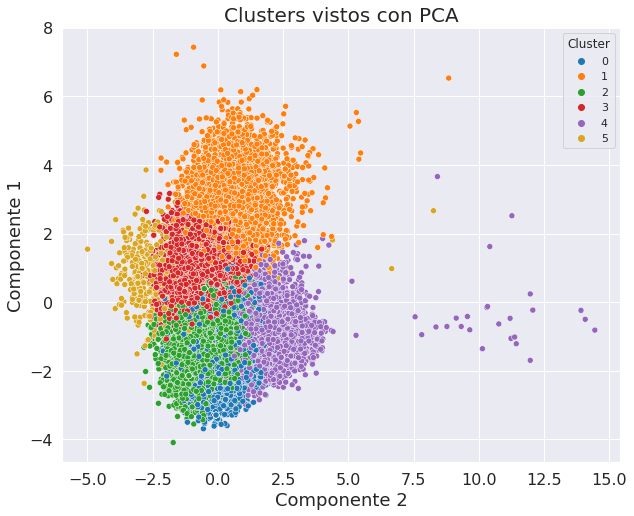

In [27]:
# Creando visualizacion de los datos con PCA

x = df_seg_pca_kmeans['Component 2']
y = df_seg_pca_kmeans['Component 1']
fig = plt.figure(figsize=(10, 8))
sns.scatterplot(x, y, hue=df_seg_pca_kmeans['Cluster'], palette = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'goldenrod'])
plt.title('Clusters vistos con PCA', fontsize=20)
plt.xlabel("Componente 2", fontsize=18)
plt.ylabel("Componente 1", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show();

# Se puede ver que hay mancha a nivel de los componentes, esto se puede mejorar tratando los atipicos

In [35]:
# Marcando cada uno de los datos con su respectivo cluster en el dataset original

data['Cluster'] = df_seg_pca_kmeans['Cluster']
data

,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,Cluster
0,"""Cats"" 1981 Original London Cast",0.598500,0.470100,267072.000000,0.376203,0.010261,0.283050,-14.434300,0.209150,114.128800,0.358320,38.200000,5,1,10,3
1,"""Cats"" 1983 Broadway Cast",0.862538,0.441731,287280.000000,0.406808,0.081158,0.315215,-10.690000,0.176212,103.044154,0.268865,31.538462,5,1,26,3
2,"""Fiddler On The Roof” Motion Picture Chorus",0.856571,0.348286,328920.000000,0.286571,0.024593,0.325786,-15.230714,0.118514,77.375857,0.354857,34.571429,0,1,7,1
3,"""Fiddler On The Roof” Motion Picture Orchestra",0.884926,0.425074,262890.962963,0.245770,0.073587,0.275481,-15.639370,0.123200,88.667630,0.372030,34.407407,0,1,27,1
4,"""Joseph And The Amazing Technicolor Dreamcoat""...",0.510714,0.467143,270436.142857,0.488286,0.009400,0.195000,-10.236714,0.098543,122.835857,0.482286,42.000000,5,1,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32534,김효근,0.939000,0.174000,341821.000000,0.321000,0.756000,0.695000,-13.411000,0.042200,138.300000,0.055400,0.000000,3,1,1,1
32535,나율,0.717000,0.591500,241281.500000,0.473500,0.000000,0.105000,-6.588500,0.053700,107.599000,0.507500,16.000000,1,1,4,3
32536,미스티,0.416000,0.686000,216715.000000,0.822000,0.000000,0.110000,-6.300000,0.080200,122.047000,0.625000,0.000000,5,0,2,0
32537,시온 Zion & 한해 Hanhae of 팬텀 Phantom,0.288000,0.739000,242480.000000,0.475000,0.000000,0.075700,-8.920000,0.379000,81.490000,0.800000,8.000000,2,0,2,0


In [39]:
# Comprobando cantidad de datos en cada Cluster

pd.value_counts(data['Cluster'])

2    10017
3     7682
1     5133
0     4614
4     4310
5      783
Name: Cluster, dtype: int64

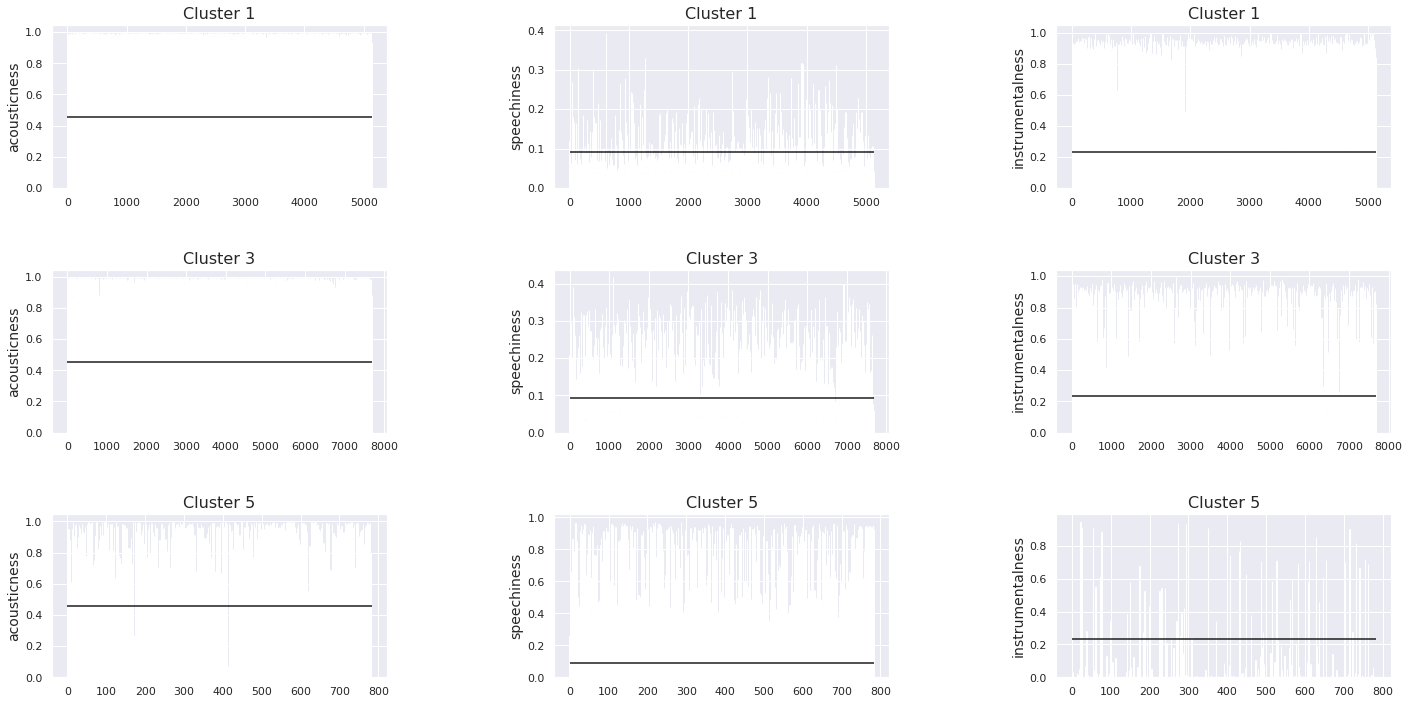

In [50]:
# Visualizando caracteristicas generales de cada cluster

clusters = [1, 3, 5]
features = ["acousticness", "speechiness", "instrumentalness"]
#colors = ['tab:green', 'tab:olive', 'tab:cyan']
dim = len(clusters)

fig, axes = plt.subplots(dim, dim, figsize=(24, 12))
i = 0
test_cluster = data.loc[data['Cluster'] == clusters[0]]
for ax in (axes.flatten()):
    if i % dim == 0 and i != 0:
        test_cluster = data.loc[data['Cluster'] == clusters[i // dim]]
    col = features[i % dim]
    y = test_cluster[col]
    x = [i for i in range(len(y))]
    ax.bar(x, y) #colors[i//dim]
    ax.set_ylabel(col, fontsize=14)
    ax.set_title("Cluster " + str(clusters[i // dim]), fontsize=16)
    ax.hlines(np.mean(data[col]), 0, len(y))
    plt.subplots_adjust(wspace=.5, hspace=.5)
    i += 1

In [53]:
# Visualizando datos de cada Cluster a nivel de filtrado

preview = data.loc[data['Cluster'] == 5]
print(len(preview))
preview.head(n=30)

783


,artists,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count,Cluster
7,"""Test for Victor Young""",0.927000,0.734000,1.756930e+05,0.474000,0.076200,0.737000,-10.544000,0.256000,132.788000,0.902000,3.000000,10,1,2,5
15,'Legally Blonde' Ensemble,0.598000,0.629667,2.084937e+05,0.510000,0.000000,0.251000,-10.526667,0.607667,95.090333,0.516333,51.666667,2,1,3,5
23,*spandrel,0.897000,0.513000,2.366440e+05,0.642000,0.034800,0.208000,-14.456000,0.367000,107.057000,0.302000,0.000000,8,0,4,5
100,"22, Little Red, Tangle Eye & Hard Hair",0.948000,0.789000,2.780820e+05,0.352000,0.000778,0.086700,-9.337000,0.660000,139.616000,0.659000,16.000000,8,1,1,5
108,2KBABY,0.512000,0.686000,1.056000e+05,0.362000,0.000000,0.168000,-12.042000,0.617000,126.700000,0.600000,70.000000,2,1,2,5
130,3B Glel,0.040735,0.827000,1.890875e+05,0.546000,0.000000,0.121350,-8.023500,0.439000,141.004500,0.266000,0.000000,5,1,8,5
287,AK97,0.074400,0.732000,2.102800e+05,0.834000,0.000000,0.562000,-6.079000,0.375000,120.163000,0.538000,15.000000,6,1,1,5
385,Absis,0.880000,0.512000,2.622180e+05,0.212000,0.000849,0.149000,-23.356000,0.865000,170.668000,0.087300,0.000000,2,1,1,5
430,Ad Kapone,0.009615,0.421500,2.840670e+05,0.696000,0.000000,0.192000,-12.542000,0.443000,79.644500,0.878500,0.000000,1,1,4,5
459,Adam Sandler,0.611882,0.513059,2.098367e+05,0.519647,0.000084,0.547671,-10.028000,0.317553,119.085588,0.513882,41.411765,9,1,17,5
